In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import zindex.zindex as zz

In [3]:

    
    #print(a[1] < b[1], a[0] < b[0], a[1] > b[1], ret)
    #return True if a[1] <= b[1] else a[0] <= b[0]
    #print(a[1] <= b[1], a[0] <= b[0]
    
zz.less_than(0,0, 0,1) # -1 or True
zz.less_than(0,0, 1,0) # -1 or True
zz.less_than(0,0, 1,1) # -1 or True

zz.less_than(1,0, 0,1) # -1 or True
zz.less_than(1,0, 1,1) # -1 or True

zz.less_than(0,1, 1,1) # -1 or True
print("-------------")

zz.less_than(0,1, 0,0) #
zz.less_than(1,0, 0,0) #
zz.less_than(1,1, 0,0) #

zz.less_than(0,1, 1,0) # False
zz.less_than(1,1, 1,0) #

zz.less_than(1,1, 0,1) #

-------------


1

In [9]:
%%time
import functools as ft
import numpy as np

print(zz.tile_children(0,0,1,1))

test_bounds = [0,0,2,2]
new_points = [ [ 0.64297498,  0.53004252], [ 0.64344366,  0.52946568]]
new_points_list = sorted(new_points, key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a,b, *test_bounds)))

assert(zz.zindex_compare(np.array([2,2]), np.array([2,2]), 0,0,8,8) == 0)
assert(zz.zindex_compare(np.array([0,4]), np.array([3,4]), 0,0,8,8) == -1)
assert(zz.zindex_compare([6,4], [3,1], 0,0,8,8) == 1)
assert(zz.zindex_compare([3,1], [2,2], 0,0,8,8) == -1)
assert(zz.zindex_compare([2,2], [3,1], 0,0,8,8) == 1)
assert(zz.zindex_compare([7,1], [2,2], 0,0,8,8) == 1)
assert(zz.zindex_compare([2,2], [7,1], 0,0,8,8) == -1)

[0.  0.  0.5 0.5 0.  0.5 0.5 1.  0.5 0.  1.  0.5 0.5 0.5 1.  1. ]
CPU times: user 1.46 s, sys: 14.6 ms, total: 1.48 s
Wall time: 1.48 s


In [10]:
%%time 

points_list = sorted([
    [6,4],[7,1],[2,2],[3,1],[3,4],[0,4],[1,6],[4,2]
], key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a,b, 0,0,8,8)))

CPU times: user 275 µs, sys: 1e+03 ns, total: 276 µs
Wall time: 279 µs


In [11]:

big_tile=[0,0,8,8]
print(points_list)

print(zz.lower_bound(points_list, [1,6], lambda a,b: zz.zindex_compare(a,b, 0,0,8,8)))
print(zz.upper_bound(points_list, [1,6], lambda a,b: zz.zindex_compare(a,b, 0,0,8,8)))
print(zz.all_points(points_list, [0.0, 0.0, 4.0, 4.0], big_tile))

print(zz.get_points(points_list, [0,0,4,4], [0,0,8,8], [0,0,16,16]))
print(zz.get_points(points_list, [0,0,5,5], [0,0,8,8], [0,0,16,16]))
print(zz.get_points(points_list, [0,0,8,1.5], [0,0,8,8], [0,0,16,16]))
new_points = [ [ 0.64297498,  0.53004252], [ 0.64344366,  0.52946568]]

new_points_list = sorted(new_points, key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a,b, *test_bounds)))
print(new_points_list)

[[3, 1], [2, 2], [7, 1], [4, 2], [0, 4], [3, 4], [1, 6], [6, 4]]
6
7
[[3, 1], [2, 2]]
[[3, 1], [2, 2]]
[[4, 2], [3, 4], [0, 4], [3, 1], [2, 2]]
[[7, 1], [3, 1]]
[[0.64344366, 0.52946568], [0.64297498, 0.53004252]]


In [149]:
import random
import zindex.zindex as zi

def run_query_z_index(new_points_list):
    #print(query_bounds)
    min_pos = [random.random(), random.random()]
    a = 1 - min_pos[0]
    b = 1 - min_pos[1]
    max_pos = [min_pos[0] + a * random.random(), min_pos[1] + b * random.random()]
    #print(min_pos, max_pos)
    query_bounds = min_pos + max_pos
    
    return zi.get_points(new_points_list, query_bounds, test_bounds, test_bounds)

In [166]:
import time
times = []

for i in ([1000, 2000, 4000]):
#for i in ([2048000, 4096000, 8192000, 16384000]):
    new_points = np.random.random((i,2))
    ts1 = time.time()
    new_points_list = sorted(new_points, 
                              key=ft.cmp_to_key(
                                  ft.partial(zz.zindex_compare,
                                             tx0= test_bounds[0],
                                             ty0=test_bounds[1], 
                                             tx1=test_bounds[2], 
                                             ty1=test_bounds[3])))
    ts2 = time.time()
    
    t1 = ts2 - ts1
    num = 20
    t2 = timeit.timeit(lambda: run_query_z_index(new_points_list), number=num)
    times += [[i, 1000 * t1, 1000 * t2 / num]]
    print(times[-1])
    
print("times:", times) 

[1000, 11.542081832885742, 59.702609095256776]
[2000, 17.956972122192383, 102.60713669704273]
[4000, 42.730093002319336, 205.06135880132206]
[8000, 85.94584465026855, 247.39904389716685]
[16000, 183.72392654418945, 381.3084511028137]
times: [[1000, 11.542081832885742, 59.702609095256776], [2000, 17.956972122192383, 102.60713669704273], [4000, 42.730093002319336, 205.06135880132206], [8000, 85.94584465026855, 247.39904389716685], [16000, 183.72392654418945, 381.3084511028137]]


In [159]:
times =  np.array([[1000, 9.168863296508789, 50.41221599676646],
[2000, 16.98470115661621, 93.40575349633582],
[4000, 36.752939224243164, 134.90044319769368],
[8000, 90.03210067749023, 215.87846255279146],
[16000, 181.4291477203369, 318.6693516501691],
[32000, 403.6710262298584, 566.6372809500899],
[64000, 885.6968879699707, 947.4282511975616],
[128000, 1955.841064453125, 1438.8111696520355],
[256000, 4423.8152503967285, 1898.9170490473043],
[512000, 9313.93575668335, 2943.4117220458575],
[1024000, 19957.006216049194, 3433.2461752987],
[2048000, 42536.39817237854, 5050.250917550875],
[4096000, 91611.70196533203, 7668.613841303159],               
])

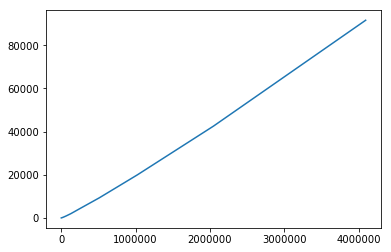

In [165]:
import matplotlib.pyplot as plt
plt.plot(times[:,0], times[:,1])

In [82]:
rect=np.frombuffer(base64.decodestring(b'JHN5J0Z44j8PYCKBtAHvP7FAiVgJaO8/MR2NwbjM7z8='), dtype=np.float64)
tile=np.frombuffer(base64.decodestring(b'qP///3Mx6z8wHY3BuMzvP6r///9zMes/Mh2NwbjM7z8='), dtype=np.float64)
 
zz.tile_children(*tile).reshape((4,-1))[0]

/Users/peter/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: decodestring() is a deprecated alias since Python 3.1, use decodebytes()
  """Entry point for launching an IPython kernel.
/Users/peter/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: decodestring() is a deprecated alias since Python 3.1, use decodebytes()
  


array([0.84978676, 0.99374044, 0.84978676, 0.99374044])

In [94]:
for c in tile:
    print('{0:.16f}'.format(c))  
print('--------------')
for child in zz.tile_children(*tile).reshape((4,-1)):
    for c in child:
        print('{0:.16f}'.format(c))
    #print("child", child, rect)
    print(zz.all_in(child, rect))

0.8497867584228418
0.9937404423043628
0.8497867584228420
0.9937404423043630
--------------
0.8497867584228418
0.9937404423043628
0.8497867584228419
0.9937404423043629
True
0.8497867584228418
0.9937404423043629
0.8497867584228419
0.9937404423043630
True
0.8497867584228419
0.9937404423043628
0.8497867584228420
0.9937404423043629
True
0.8497867584228419
0.9937404423043629
0.8497867584228420
0.9937404423043630
True


In [90]:
zz.all_in(tile, rect)

ret1: False
ret2: False


False

In [ ]:
times1 = np.array([
    [1000, 159, 118],
    [2000, 374, 217],
    [4000, 810, 281],
    [8000, 1740, 462],
    [16000, 3880, 1000],
    [32000, 8810, 1350],
    [64000, 19800, 1470],
    [132000, 45000, 2830]
])